In [1]:
%matplotlib inline
import numpy as np
from stingray.pulse.search import epoch_folding_search, z_n_search
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)

# Simulate a dataset

Let us simulate a pulsar: we create a sinusoidal light curve and use Stingray's event simulator (in `Eventlist.simulate_times`) to simulate an event list with that light curve.

In [2]:
def sinusoid(times, frequency, baseline, amplitude, phase):
    return baseline + amplitude * np.sin(2 * np.pi * (frequency * times + phase))

In [3]:
from stingray import Lightcurve

period = 1.203501
mean_countrate = 100
pulsed_fraction = 0.2
bin_time = 0.001

t = np.arange(0, 1000, bin_time)

# The continuous light curve
counts = sinusoid(t, 1 / period, mean_countrate, 
                  0.5 * mean_countrate * pulsed_fraction, 0) * bin_time
lc = Lightcurve(t, counts, gti=[[-bin_time / 2, 1000 + bin_time / 2]], dt=bin_time)

In [4]:
from stingray.events import EventList

# use the light curve above to simulate an event list for this pulsar.
events = EventList()
events.simulate_times(lc)

# Pulsation search with epoch folding.

Let us assume we have already an estimate of the pulse period, for example because we found a candidate in the power density spectrum with a period of ~1.2.
We search around that period with the epoch folding.

Epoch folding consists of cutting the light curve at every pulse period and summing up all the intervals obtained in this way. We get an average pulse profile. In this example,

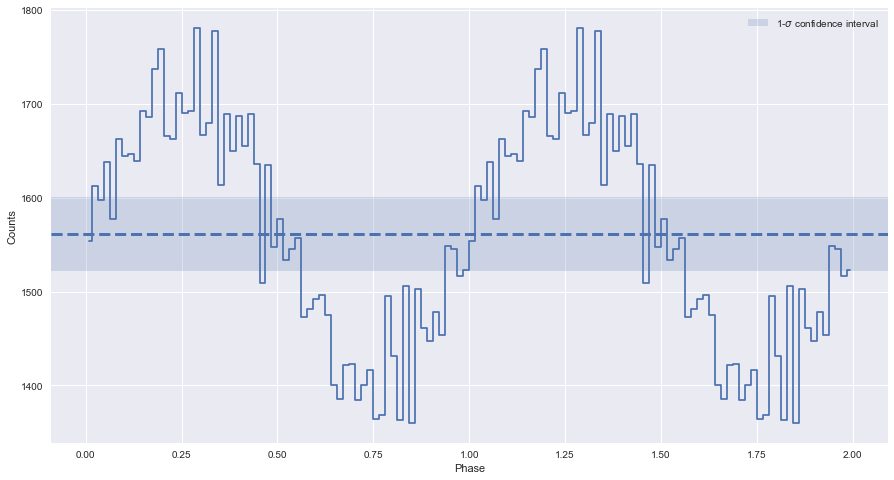

In [5]:
from stingray.pulse.pulsar import fold_events
nbin =64

ph, profile, profile_err = fold_events(events.time, 1/period, nbin=nbin)

plt.plot(np.concatenate([ph, ph + 1]), np.concatenate([profile, profile]),
         drawstyle='steps-mid')

mean_prof = np.mean(profile)
std_poisson = np.sqrt(mean_prof)
plt.axhline(mean_prof, ls='--', lw=3)
plt.axhspan(mean_prof - std_poisson, mean_prof + std_poisson, 
            alpha=0.2, label='1-$\sigma$ confidence interval')
plt.xlabel('Phase')
plt.ylabel('Counts')
plt.legend()

where the pulse was plotted twice for visual clarity. If the candidate pulse frequency was even slightly incorrect, we would have obtained a much shallower pulse profile, or no pulse profile at all. E.g.

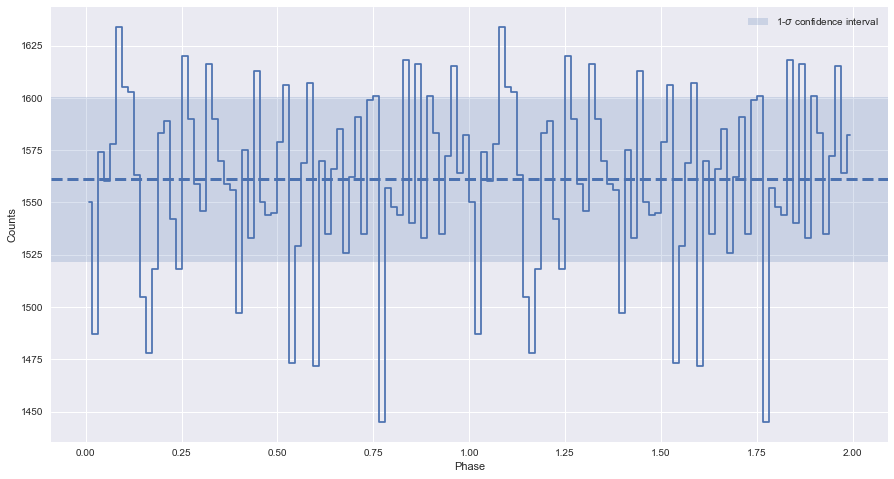

In [6]:
ph, profile, profile_err = fold_events(events.time, 1/1.1, nbin=nbin)

plt.plot(np.concatenate([ph, ph + 1]), np.concatenate([profile, profile]),
         drawstyle='steps-mid')
mean_prof = np.mean(profile)
std_poisson = np.sqrt(mean_prof)
plt.axhline(mean_prof, ls='--', lw=3)
plt.axhspan(mean_prof - std_poisson, mean_prof + std_poisson, 
            alpha=0.2, label='1-$\sigma$ confidence interval')

plt.xlabel('Phase')
plt.ylabel('Counts')
plt.legend()

Therefore, typically we try a number of frequencies around the candidate we found with the power spectrum or other means, and search for the frequency that gives the "best" pulsed profile. 
How do we evaluate this best frequency?
We use the chi squared statistics. 

We use a flat pulsed profile (no pulsation) as model, and we calculate the chi square of the actual pulsed profile with respect to this flat model:

$$
S = \sum_i\frac{(P_i - \overline{P})^2}{\sigma^2}
$$
If there is no pulsation, the chi squared will assume a random value distributed around the number of degrees of freedom $n - 1$ (where $n$ is the number of bins in the profile) with a well defined statistical distribution ($\chi^2_{n - 1}$). If there is pulsation, the value will be much larger.
Stingray has a function that does this: `stingray.pulse.search.epoch_folding_search`.

For the frequency resolution of the periodogram, one usually chooses _at least_ the same frequency resolution of the FFT, i. e., $df_{\rm min}=1/(t_1 - t_0)$. In most cases, a certain degree of oversampling is used.

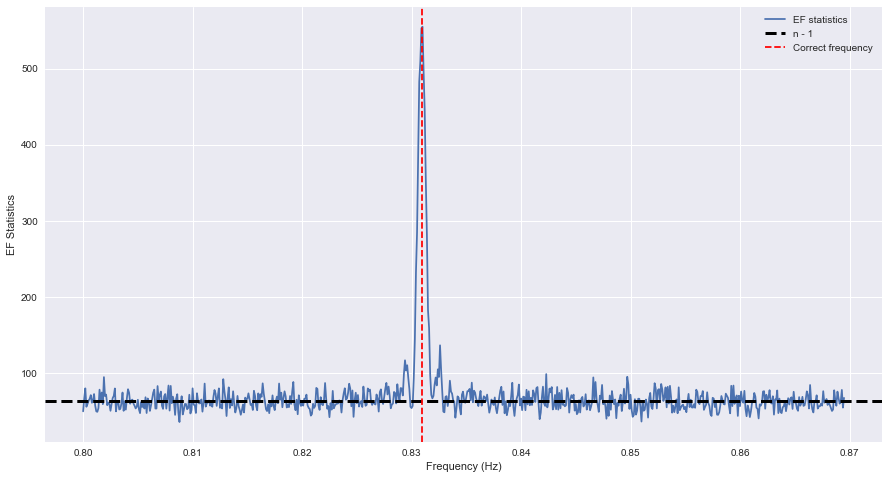

In [7]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
df_min = 1/1000 # 1/length
frequencies = np.arange(1/1.25, 1/1.15, 0.1 * df_min)
freq, efstat = epoch_folding_search(events.time, frequencies, nbin=nbin)

plt.plot(freq, efstat, label='EF statistics')
plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
plt.axvline(1/period, ls='--', color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.legend()

A peak is definitely there. 
Far from the peak, the periodogram follows approximately a **$\chi^2$ distribution with $n - 1$ degrees of freedom**, where $n$ is the number of bins in the pulse profile used to calculate the statistics. In fact, its mean is $n-1$ as shown in the figure. 

But close to the correct frequency, as described in Leahy et al. 1983, 1987 the peak in the epoch folding periodogram has the shape of a **sinc squared function** (whose secondary lobes are in this case drown in noise).

# Z-squared search
The epoch folding statistics has no information on the actual shape of the profile. 

A better method is the **$Z^2$ statistics** (Buccheri et al. 1983), which is conceptually similar to the Epoch folding but has high values when the signal is well described by a small number of **sinusoidal harmonics**. 

$Z^2_n = \dfrac{2}{N} \sum_{k=1}^n \left[{\left(\sum_{j=1}^N \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^N \sin k \phi_j\right)}^2\right]$

Where $N$ is the number of photons, $n$ is the number of harmonics and $\phi_j$ are the phases corresponding to the event arrival times $t_j$ ($\phi_j = \nu t_j$, where $\nu$ is the pulse frequency).

The $Z_n^2$ statistics defined in this way, far from the pulsed profile, follows a $\chi^2_n$ distribution, where $n$ is the number of harmonics this time.

Stingray implements the $Z$ search in `stingray.pulse.search.z_n_search`.
The standard $Z^2$ search calculates the phase of each photon and calculates the sinusoidal functions above for each photon. This is very computationally expensive if the number of photons is high. Therefore, in Stingray, the search is performed by binning the pulse profile first and using the phases of the folded profile in the formula above, multiplying the squared sinusoids of the phases of the pulse profile by a weight corresponding to the number of photons at each phase.

$Z^2_n = \dfrac{2}{\sum_j{w_j}} \sum_{k=1}^n \left[{\left(\sum_{j=1}^m w_j \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^m w_j \sin k \phi_j\right)}^2\right]$

Since the sinusoids are only executed on a small number of bins, while the epoch folding procedure just consists of a very fast histogram-like operation, the speedup of this new formula is obvious. Care must be put into the choice of the number of bins, in order to maintain a good approximation even when the number of harmonics is high. As a rule of thumb, use _a number of bins at least 10 times larger than the number of harmonics_.

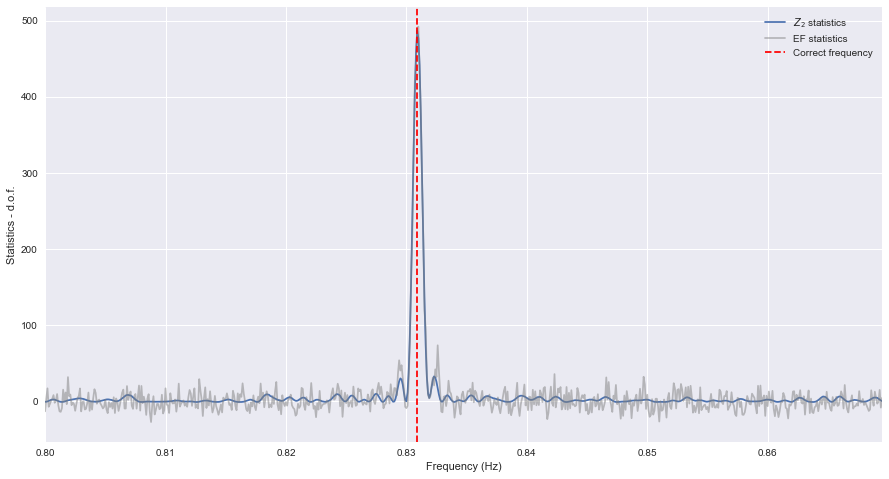

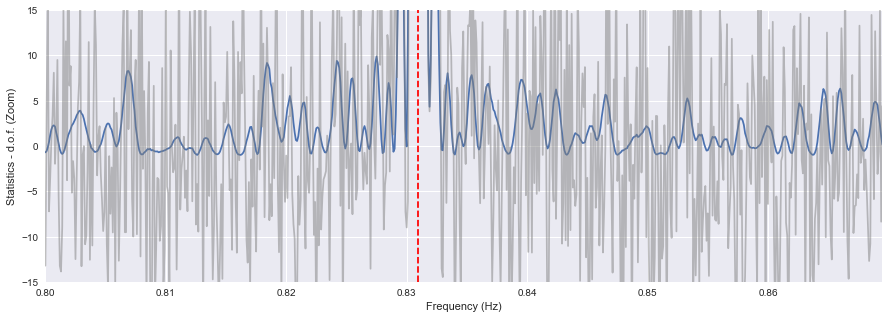

In [8]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
nharm = 1
frequencies = np.arange(1/1.25, 1/1.15, 0.1/1000)
freq, zstat = z_n_search(events.time, frequencies, nbin=nbin, nharm=nharm)

plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, ls='--', color='r', label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()
plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, ls='--', color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, 15])
_ = plt.xlim([frequencies[0], frequencies[-1]])


# Thresholding

When can a peak in the EF or $Z_n^2$ periodogram be considered a pulsation?

Since both the EF and $Z_n^2$ of noise follow precise statistical distributions ($\chi^_{\rm nbin}$ in one case, $\chi^2_n$ in the other), we can use the inverse survival functions of these statistical distributions to find the peaks that are not expected by noise.

In Stingray, the thresholds are defined in `stingray.pulse.pulsar.fold_detection_level` and `stingray.pulse.pulsar.z2_n_detection_level` respectively.

The `ntrial` parameter should be set to an estimate of the statistically independent frequencies in the periodogram. A good estimate can be 

$$N_{\rm trial} \sim (f_{\rm max} - f_{\rm min}) / df_{\rm min} =(f_{\rm max} - f_{\rm min}) (t_1 - t_0)$$,
where $f_{\rm min}$ and $f_{\rm max}$ are the maximum and minimum frequencies of the periodogram, $df_{\rm min}$ was defined above and $t_0$ ans $t_1$ the start and end of the observation.

Moreover, the `stingray.pulse.search.search_best_peaks` helps finding the best value for nearby candidates.

/Users/marta/miniconda/envs/py35/lib/python3.5/site-packages/stingray-0.1.dev1035-py3.5.egg/stingray/utils.py:47: UserWarning: SIMON says: Z2_n: The treatment of ntrial is very rough. Use with caution
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/marta/miniconda/envs/py35/lib/python3.5/site-packages/stingray-0.1.dev1035-py3.5.egg/stingray/utils.py:47: UserWarning: SIMON says: fold: The treatment of ntrial is very rough. Use with caution
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


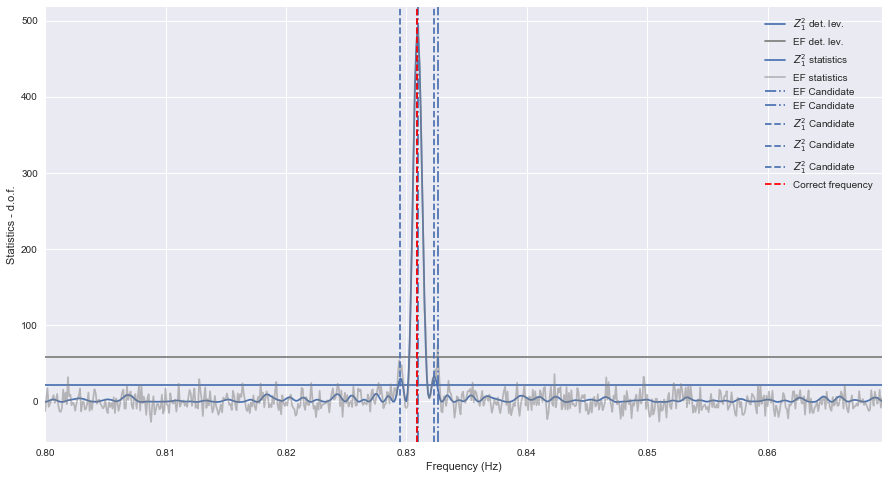

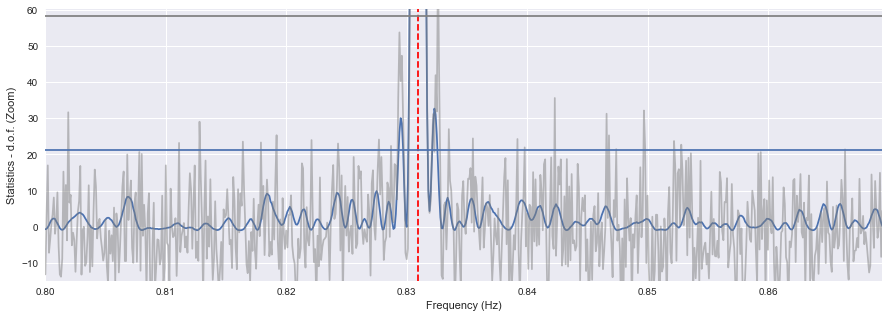

In [9]:
from stingray.pulse.search import search_best_peaks
from stingray.pulse.pulsar import fold_detection_level, z2_n_detection_level

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.01, ntrial=len(freq))
ef_detlev = fold_detection_level(nbin, epsilon=0.01, ntrial=len(freq))

cand_freqs_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z = search_best_peaks(freq, zstat, z_detlev)

plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate')
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate')
    
plt.axvline(1/period, ls='--', color='r', label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, ls='--', color='r', label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')


plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])



# Fit peak with Sinc-squared and Gaussian functions

As we saw earlier, if the pulse frequency is stable during the observation, the peak shape is a **sinc squared function**. Therefore we fit it to the peak with the function `stingray.pulse.modeling.fit_sinc`.  
We have two possibilities:

+ if `obs_length` is the length of the observation. If it is defined, it fixes width to $1/(\pi*obs length)$, as expected from epoch folding periodograms. The other two free parameters are `amplitude` and `mean`.
+ if it is not defined, the `width` parameter can be used.

On the other hand, if the pulse frequency varies slightly, the peak oscillate and the integrated profile is a bell-shaped function. We can fit it with a **gaussian function**  (`stingray.pulse.modeling.fit_gaussian`) with the standard parameters: `amplitude`, `mean`, `stddev`.

We also provide the user with the constrains `fixed`, `tied`, `bounds`, in order to fix, link and/or constrain parameters.




In [10]:
from stingray.pulse.modeling import fit_sinc

fs=fit_sinc(freq, efstat-(nbin-1),amp=max(efstat-(nbin-1)), mean=cand_freqs_ef[0], obs_length=1000.)

/Users/marta/miniconda/envs/py35/lib/python3.5/site-packages/stingray-0.1.dev1035-py3.5.egg/stingray/pulse/modeling.py:20: RuntimeWarning: invalid value encountered in true_divide
  values = np.sin(x) / x
/Users/marta/miniconda/envs/py35/lib/python3.5/site-packages/stingray-0.1.dev1035-py3.5.egg/stingray/pulse/modeling.py:86: RuntimeWarning: divide by zero encountered in true_divide
  - np.sin((x-mean)/width)) / ((x-mean)/width)**2
/Users/marta/miniconda/envs/py35/lib/python3.5/site-packages/stingray-0.1.dev1035-py3.5.egg/stingray/pulse/modeling.py:89: RuntimeWarning: invalid value encountered in multiply
  d_width = d_x*(-(x-mean)/(width)**2)


/Users/marta/miniconda/envs/py35/lib/python3.5/site-packages/stingray-0.1.dev1035-py3.5.egg/stingray/pulse/modeling.py:20: RuntimeWarning: invalid value encountered in true_divide
  values = np.sin(x) / x


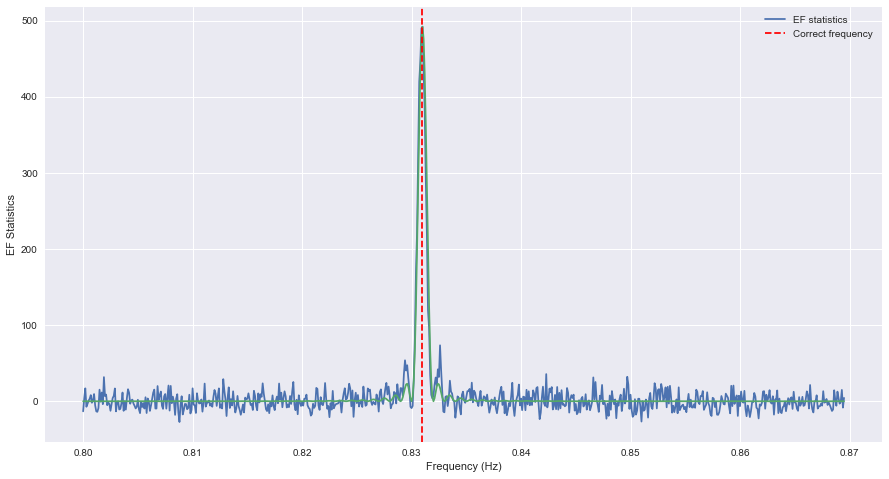

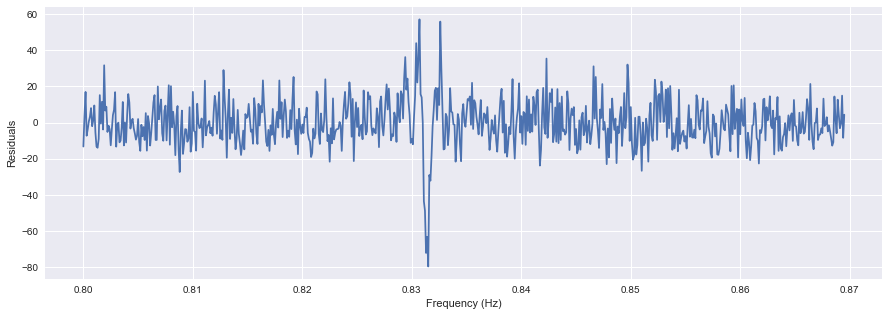

In [11]:
plt.plot(freq, efstat-(nbin-1), label='EF statistics')
plt.plot(freq, fs(freq))
plt.axvline(1/period, ls='--', color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, efstat-(nbin-1)-fs(freq))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Residuals')

In [12]:
from stingray.pulse.modeling import fit_gaussian

fg=fit_gaussian(freq, efstat-(nbin-1),amplitude=max(efstat-(nbin-1)), mean=cand_freqs_ef[0], stddev=1/(np.pi*1000))

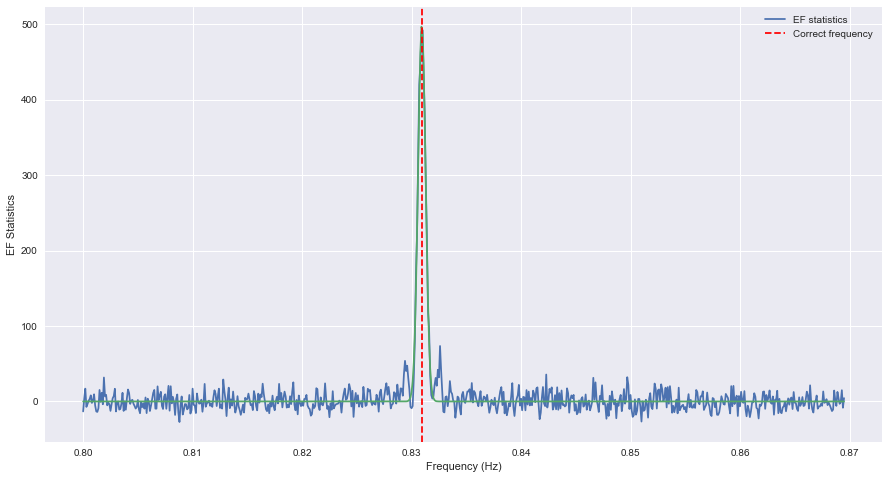

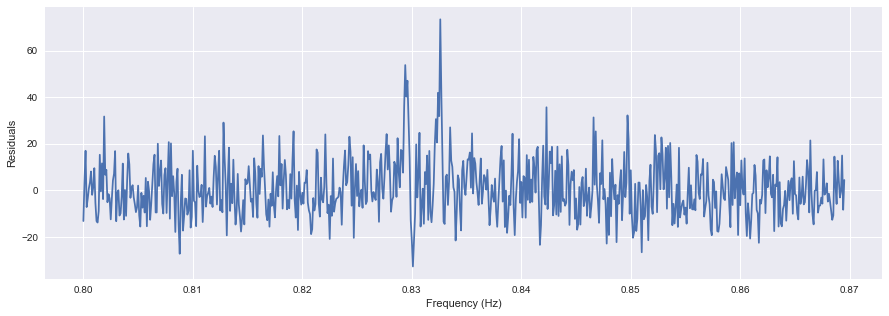

In [13]:
plt.plot(freq, efstat-(nbin-1), label='EF statistics')
plt.plot(freq, fg(freq))
plt.axvline(1/period, ls='--', color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, efstat-(nbin-1)-fg(freq))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Residuals')